# Wrangle Review Data
<p>Wrangling Reviews is pretty simple, we are only concerned with reviews given to businesses that are Arizona Restaurants so the first step is to only keep reviews from the source review.json file that are for businesses that we cleaned in the Business Data Wrangling Notebook.</p>
    
<p>Next we are trying to preserve as much information as possible when cleaning review text so we are only removing commas.  Finally, after inspecting the length of reviews, we are keeping only reviews with 80 or more characters.  This 80 character limit reduces the 501250 reviews to a subset of 495894 reviews.</p>

<p>The 80 Character cut off is used after an inspection into length of the shortest 5% quantile review text length year over year.  The 5% quantile rarely drops below 85 characters in any subset of reviews by date, restaurant, or fast_food type</p>

## Step 0: Import packages and establish chart output standards

In [1]:
import numpy as np
import pandas as pd
import datetime
import json

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 15

FIG_SIZE = (15,6)

DO_WRITE_CHARTS = True

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

def time_marker(text=''):
    print('[{}] {}'.format(datetime.datetime.now().time(), text.lower()))

# Step 1: Load Cleaned Business Data
<p>Load cleaned Arizona Restaurant Data from csv file and extract `business_id` values.  Load reviews and keep only those given to these Arizona Restaurants</p>

In [3]:
restaurant_data = pd.read_csv('../clean_data/az_restaurant_business_clean.csv', index_col=0)
restaurant_bids = restaurant_data.business_id.values
time_marker('{:d} Restaurant business_id values'.format(len(restaurant_bids)))

[00:42:21.768811] 7066 restaurant business_id values


In [4]:
restaurant_data.head(3)

,business_id,categories,city,is_open,name,postal_code,review_count,stars,is_fast_food
0,1WBkAuQg81kokZIPMpn9Zg,"['burgers', 'restaurants']",Phoenix,1,Charr An American Burger Bar,85022.0,232,3.0,0
1,kKx8iCJkomVQBdWHnmmOiA,"['restaurants', 'pizza']",Mesa,1,Little Caesars Pizza,85209.0,4,2.5,0
2,VdlPZg2NAu8t8GkdbPLecg,"['restaurants', 'gluten-free', 'indian', 'seaf...",Scottsdale,1,Tandoori Times Indian Bistro,85258.0,263,3.5,0


# Step 2: Load Review Data for All Arizona Restaurants
<p><b>WARNING: Loading Reviews takes roughly 25 minutes</b></p>

In [5]:
all_restaurant_reviews = []

source_data_file = '../source_data/review.json'

# read the file line by line and save only lines we need
with open(source_data_file, 'r') as review_file:
    for i, review_json in enumerate(review_file):
        review = json.loads(review_json)

        # append to restaurant reviews
        if review['business_id'] in restaurant_bids:
            all_restaurant_reviews.append(review)
            
        if i % 100000 == 0 and i != 0:
            time_marker('\tfound {:>7}/{:>7} Reviews so far {:2.4f} '.format(str(len(all_restaurant_reviews)),str(i),
                                                                                 len(all_restaurant_reviews)/(i+1)*100.))
        
print('Selected {:d} Arizona Restaurant Reviews from {:d} total reviews'.format(len(all_restaurant_reviews), i))
reviews_df = pd.DataFrame(all_restaurant_reviews)

[00:42:51.191931] 	found    9625/ 100000 reviews so far 9.6249 
[00:43:21.955381] 	found   18668/ 200000 reviews so far 9.3340 
[00:43:53.237465] 	found   28694/ 300000 reviews so far 9.5646 
[00:44:24.469043] 	found   38071/ 400000 reviews so far 9.5177 
[00:44:54.762903] 	found   47797/ 500000 reviews so far 9.5594 
[00:45:25.857558] 	found   57664/ 600000 reviews so far 9.6107 
[00:45:56.026211] 	found   67591/ 700000 reviews so far 9.6558 
[00:46:28.725520] 	found   76961/ 800000 reviews so far 9.6201 
[00:46:59.421784] 	found   87039/ 900000 reviews so far 9.6710 
[00:47:29.240339] 	found   96610/1000000 reviews so far 9.6610 
[00:47:59.192701] 	found  106025/1100000 reviews so far 9.6386 
[00:48:31.279439] 	found  115480/1200000 reviews so far 9.6233 
[00:49:02.379179] 	found  124914/1300000 reviews so far 9.6088 
[00:49:39.257880] 	found  134446/1400000 reviews so far 9.6033 
[00:50:10.193917] 	found  144171/1500000 reviews so far 9.6114 
[00:50:39.261247] 	found  153852/1600000

In [6]:
reviews_df.head(3)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,JlNeaOymdVbE6_bubqjohg,0,2014-08-09,0,BF0ANB54sc_f-3_howQBCg,1,We always go to the chevo's in chandler which ...,3,ssuXFjkH4neiBgwv-oN4IA
1,0Rni7ocMC_Lg2UH0lDeKMQ,0,2014-08-09,0,DbLUpPT61ykLTakknCF9CQ,1,"This place is always so dirty and grimy, been ...",6,ssuXFjkH4neiBgwv-oN4IA
2,S-oLPRdhlyL5HAknBKTUcQ,0,2017-11-30,0,z_mVLygzPn8uHp63SSCErw,4,Holy portion sizes! You get a lot of bang for ...,0,MzEnYCyZlRYQRISNMXTWIg


# Step 3: Inspect Review Star Distribution

In [7]:
# extract business ids for fast food locations
fast_food_indicator = restaurant_data[['business_id', 'is_fast_food']].copy()

# append is_fast_food to reviews
reviews_df = reviews_df.merge(fast_food_indicator, on='business_id', how='left')

# subset into fast food and non ast food reviews
ff_reviews_df  = reviews_df[reviews_df.is_fast_food == 1].copy()
nff_reviews_df = reviews_df[reviews_df.is_fast_food == 0].copy()

In [8]:
def plot_rating_distribution(df, title_suffix = '', file_name='test', color='k'):
    
    df = df.groupby('stars').count()['business_id'].copy()
    df = df/df.max()
    
    ax = df.plot(kind='bar', figsize=FIG_SIZE, color=color)
    
    if len(title_suffix) > 0:
        ax.set_title('Review Star Distribution in {}'.format(title_suffix), size=TITLE_FONT_SIZE)
    else:
        ax.set_title('Review Star Distribution', size=TITLE_FONT_SIZE)
        
    ax.set_ylabel('Distribution', size=LABEL_FONT_SIZE)
    ax.set_xlabel('Review Star Rating', size=LABEL_FONT_SIZE)
    ax.set_xticklabels(df.index.values, size=TICK_FONT_SIZE, rotation=0)
    ax.legend('')
    plt.tight_layout()
    if DO_WRITE_CHARTS:
        plt.savefig('../charts/{}_review_star_distribution.png'.format(file_name))
    plt.show()
    plt.close()



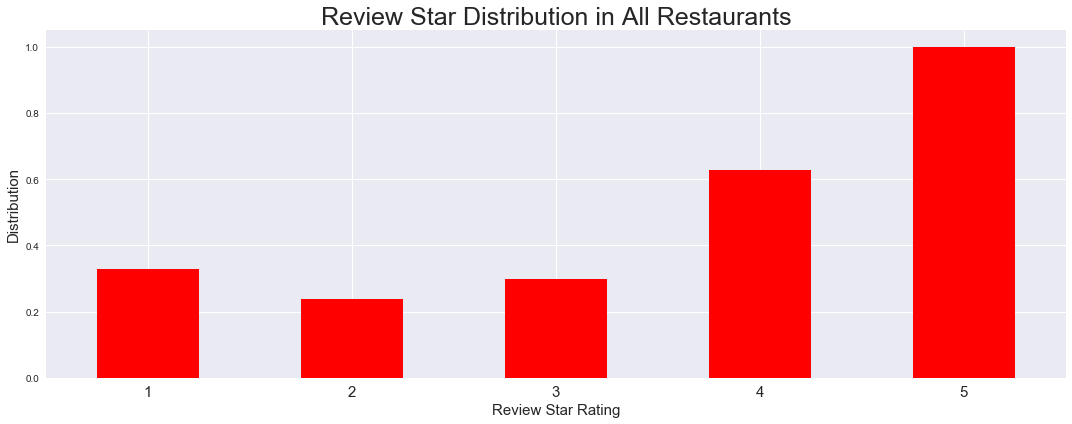

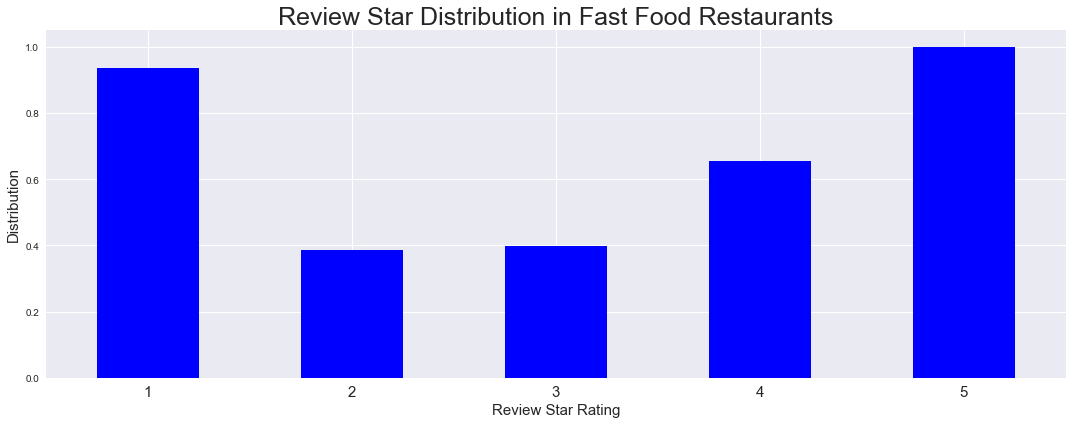

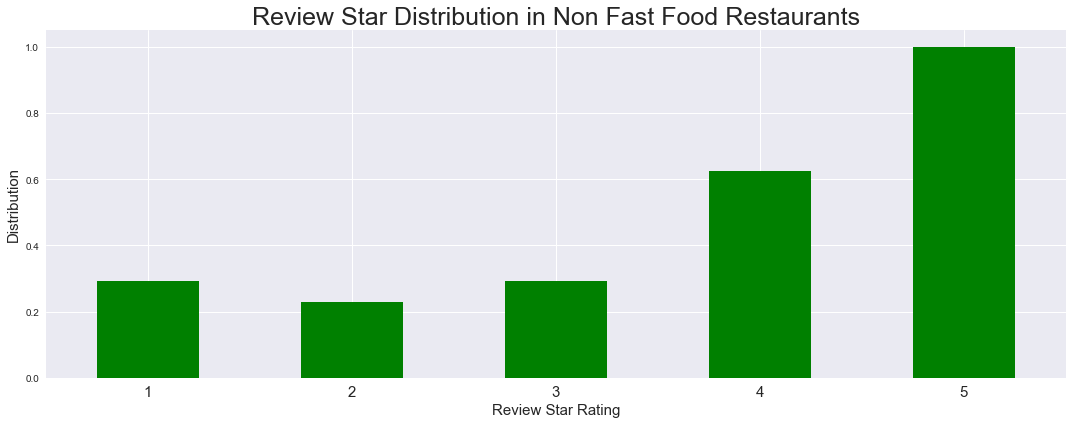

In [9]:
plot_rating_distribution(reviews_df, title_suffix = 'All Restaurants', file_name='all_restaurants', color='r')
plot_rating_distribution(ff_reviews_df, title_suffix = 'Fast Food Restaurants', file_name='ff_restaurants', color='b')
plot_rating_distribution(nff_reviews_df, title_suffix = 'Non Fast Food Restaurants', file_name='nff_restaurants', color='g')

# Step 4: Sanitize Review Text for CSV
<p>For now, to retain as much information as possible, just remove commas from review text.</p>

In [10]:
reviews_df['text'] = reviews_df.text.apply(lambda x: x.replace(',', '').lower())
reviews_df['review_len'] = reviews_df.text.str.len()

# Step 5: Set Column data types

In [11]:
reviews_df['date'] = pd.to_datetime(reviews_df['date'])

reviews_df['business_id'] = reviews_df['business_id'].astype('str')
reviews_df['review_id'] = reviews_df['review_id'].astype('str')
reviews_df['text'] = reviews_df['text'].astype('str')
reviews_df['user_id'] = reviews_df['user_id'].astype('str')
reviews_df['text'] = reviews_df['text'].astype('str')

reviews_df['cool'] = reviews_df['cool'].astype('int')
reviews_df['funny'] = reviews_df['funny'].astype('int')
reviews_df['stars'] = reviews_df['stars'].astype('int')
reviews_df['useful'] = reviews_df['useful'].astype('int')
reviews_df['is_fast_food'] = reviews_df['is_fast_food'].astype('int')

In [12]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501250 entries, 0 to 501249
Data columns (total 11 columns):
business_id     501250 non-null object
cool            501250 non-null int64
date            501250 non-null datetime64[ns]
funny           501250 non-null int64
review_id       501250 non-null object
stars           501250 non-null int64
text            501250 non-null object
useful          501250 non-null int64
user_id         501250 non-null object
is_fast_food    501250 non-null int64
review_len      501250 non-null int64
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 45.9+ MB


# Step 6: Pruning Short Reviews
<p>The 80 Character cut off is used after an inspection into length of the shortest 5% quantile review text length year over year.  The 5% quantile rarely drops below 85 charcters in any subset of reviews by date, restaurant, or fast_food type</p>

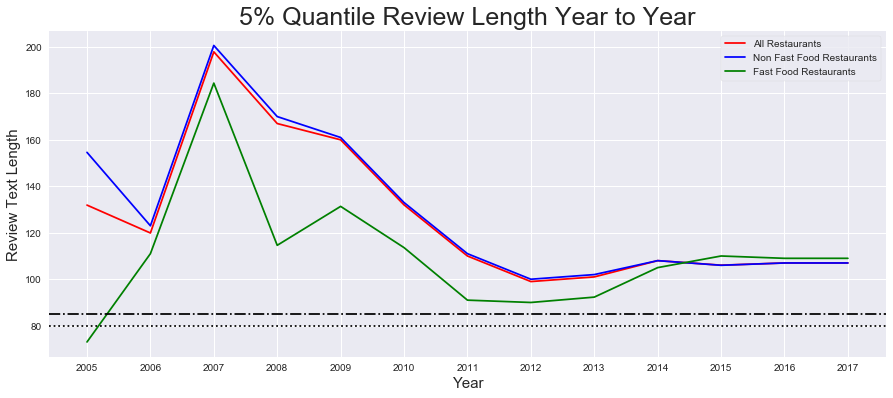

In [13]:
nff_reviews_df = reviews_df[reviews_df.is_fast_food == 0].copy()
ff_reviews_df = reviews_df[reviews_df.is_fast_food == 1].copy()

quant = 0.05

ax = reviews_df.groupby([reviews_df.date.dt.year]).quantile(quant)['review_len'].plot(figsize=FIG_SIZE, color='r')
nff_reviews_df.groupby([nff_reviews_df.date.dt.year]).quantile(quant)['review_len'].plot(ax=ax, color='b')
ff_reviews_df.groupby([ff_reviews_df.date.dt.year]).quantile(quant)['review_len'].plot(ax=ax, color='g')

ax.set_title('5% Quantile Review Length Year to Year', size=TITLE_FONT_SIZE)
ax.set_xlabel('Year', size=LABEL_FONT_SIZE)
ax.set_ylabel('Review Text Length', size=LABEL_FONT_SIZE)

ax.axhline(80, linestyle=':', color='k')
ax.axhline(85, linestyle='-.', color='k')

ax.set_xticks(reviews_df.groupby(reviews_df.date.dt.year).quantile(quant)['review_len'].index)

ax.legend(['All Restaurants', 'Non Fast Food Restaurants', 'Fast Food Restaurants'], loc=1, frameon=True)

if DO_WRITE_CHARTS:
        plt.savefig('../charts/review_length_Q05_yearly.png')
plt.show()
plt.close()

In [14]:
min_review_len = 80
reviews_df_count = reviews_df.shape[0]
reviews_df = reviews_df[reviews_df.review_len >= min_review_len].copy()
reviews_df.reset_index(inplace=True, drop=True)
print('Reduced {:d} reviews to a subset of {:d} reviews {:2.4f} [reviews_df]'.format(reviews_df_count, 
                                                                                        reviews_df.shape[0], 
                                                                                        (100.*reviews_df.shape[0]/reviews_df_count)))

Reduced 501250 reviews to a subset of 495894 reviews 98.9315 [reviews_df]


In [15]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495894 entries, 0 to 495893
Data columns (total 11 columns):
business_id     495894 non-null object
cool            495894 non-null int64
date            495894 non-null datetime64[ns]
funny           495894 non-null int64
review_id       495894 non-null object
stars           495894 non-null int64
text            495894 non-null object
useful          495894 non-null int64
user_id         495894 non-null object
is_fast_food    495894 non-null int64
review_len      495894 non-null int64
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 41.6+ MB


# Step 7: Write Cleaned Data to File
<p>Write data frame of only Arizona Restaurant reviews to file</p>

In [16]:
file_name = '../clean_data/az_restaurant_reviews.csv'
time_marker(text='Writing {:d} records to file {}'.format(reviews_df.shape[0], file_name))
reviews_df.to_csv(file_name, encoding='utf-8')

time_marker('complete!')

[01:10:19.803841] writing 495894 records to file ../clean_data/az_restaurant_reviews.csv
[01:10:41.598113] complete!


# Step 8: Inspect Updated Star Distribution Graphs

In [17]:
nff_reviews_df = reviews_df[reviews_df.is_fast_food == 0].copy()
ff_reviews_df = reviews_df[reviews_df.is_fast_food == 1].copy()

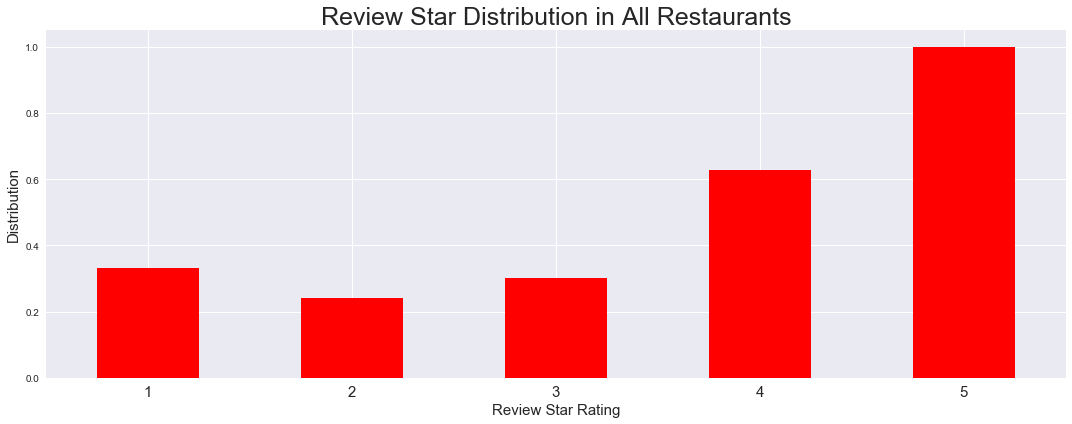

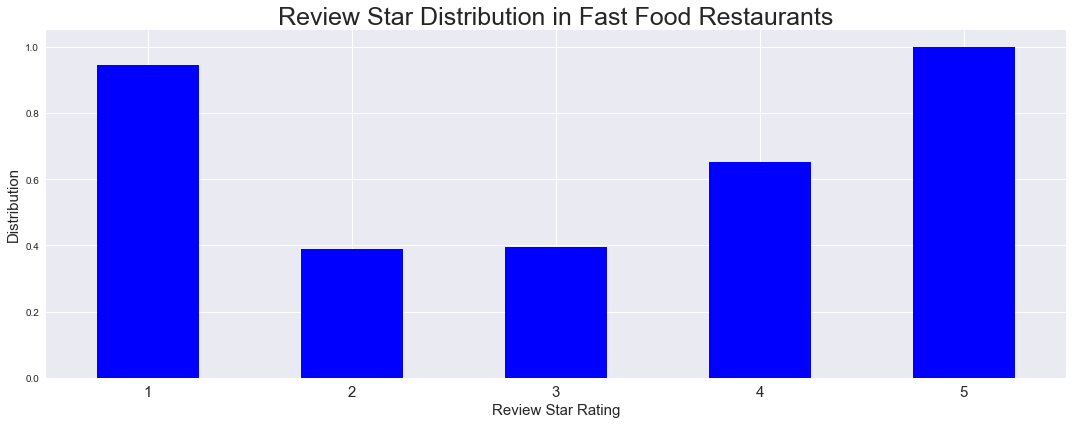

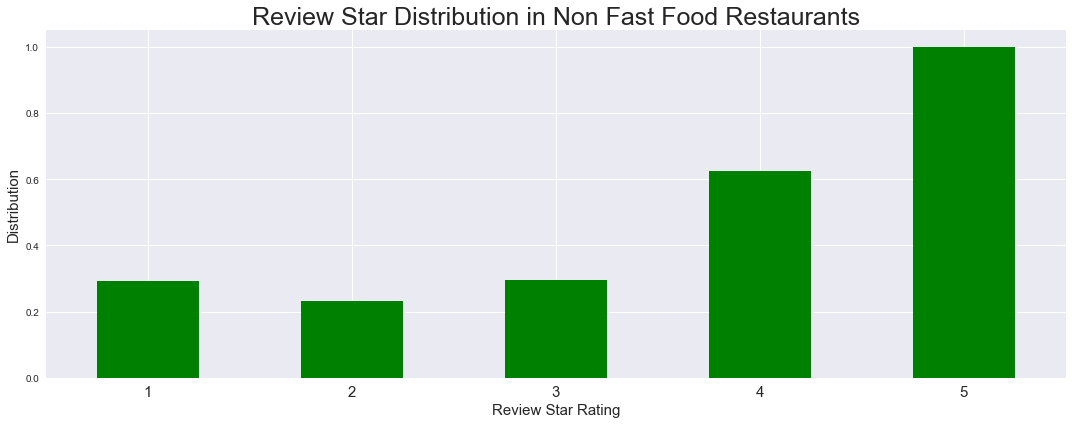

In [18]:
plot_rating_distribution(reviews_df, title_suffix = 'All Restaurants', file_name='all_restaurants_cleaned', color='r')
plot_rating_distribution(ff_reviews_df, title_suffix = 'Fast Food Restaurants', file_name='ff_restaurants_cleaned', color='b')
plot_rating_distribution(nff_reviews_df, title_suffix = 'Non Fast Food Restaurants', file_name='nff_restaurants_cleaned', color='g')

In [19]:
reviews_df.head(3)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,is_fast_food,review_len
0,JlNeaOymdVbE6_bubqjohg,0,2014-08-09,0,BF0ANB54sc_f-3_howQBCg,1,we always go to the chevo's in chandler which ...,3,ssuXFjkH4neiBgwv-oN4IA,0,422
1,0Rni7ocMC_Lg2UH0lDeKMQ,0,2014-08-09,0,DbLUpPT61ykLTakknCF9CQ,1,this place is always so dirty and grimy been t...,6,ssuXFjkH4neiBgwv-oN4IA,0,111
2,S-oLPRdhlyL5HAknBKTUcQ,0,2017-11-30,0,z_mVLygzPn8uHp63SSCErw,4,holy portion sizes! you get a lot of bang for ...,0,MzEnYCyZlRYQRISNMXTWIg,0,130


In [20]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495894 entries, 0 to 495893
Data columns (total 11 columns):
business_id     495894 non-null object
cool            495894 non-null int64
date            495894 non-null datetime64[ns]
funny           495894 non-null int64
review_id       495894 non-null object
stars           495894 non-null int64
text            495894 non-null object
useful          495894 non-null int64
user_id         495894 non-null object
is_fast_food    495894 non-null int64
review_len      495894 non-null int64
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 41.6+ MB
